# Overview

**GENERAL THOUGHTS:**



**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

continuous data:
- Impute missing data: SimpleImputer(strategy='median')
- Standardize data: StandardScaler()

categorical data:
- Impute missing data: SimpleImputer(strategy='most_frequent')
- Ordinal & Nominal data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

target data:
- target encoding: LabelEncoder()

**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
Models:
  - [X] Neural Net: Multi Layer Perceptron (MLP)
  - [X] Neural Net: MLP with categorical variable embedding (embMLP)


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.ensemble import RandomForestClassifier

# import xgboost as xgb
# import lightgbm as lgbm

import imblearn
from imblearn.over_sampling import RandomOverSampler

import optuna

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42

In [4]:
from typing import Dict, Iterable, List, Optional, Tuple, Union, Literal

import lightning as L
from lightning.pytorch.tuner import Tuner
# from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassF1Score
# from torcheval.metrics.functional import multiclass_f1_score
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping

# Load Data using Dataset Class

## Datasets, DataLoaders & LightningDataModule
- Logic of using `Datasets`, `DataLoaders` & `LightningDataModule` for **Tabular Data**  
    Since we are using tabular data and want to perform non tensor based processing to our date, we use Datasets, DataLoaders & LightningDataModule in a different manner as we would do when applying tensor operations (incl. tensor based preprpcessing) only.  
    - `LightningDataModule` 
        Our LightningDataModule builds the wrapper around this process, with the following intensions:
        - `def prepare_data`  
        Data Operations that only should be performed once on the data (and should not be performed on a distributed manner). Prepares the data for data pre-processing e.g. using sklearn.  
            - Loading the data from .csv to pd.DataFrame
            - General dataset preperations like feature selection and data type correction
        - `def setup`  
        First, data operations (like shuffle, split data, categorical encoding, normalization, etc.), which any dataframe should undergo before feeding into the dataloader will be performed here. Since we use sklearn functionalities for our tabular pre-processing pipeline the data input and output of the pre-processing is a tabular format (dataframe) and not a tensor format.
        Second, the outcome of `def setup` are `Dataset` objects for each split (e.g. train, val, test, pred), which is a wrapper around the pre-processed tabular data and provides the samples and their corresponding labels (ideally in tensor format) in a specific way to be compatible for the model(s).
            - `Dataset`  
            Dataset provides the samples and their corresponding labels in a specific way to be compatible for the model(s). We define the input for our tabular use case as a DataFrame, while the output should generally be a tensor. In our case the output is a tuple of a flattern tensor representing all features and a tensor for the target variable (label). This aligns with the input if a simple MLP model. For more complex models, e.g. that handle continous and categorical variables differently, this should be adapted.  
            The class performs specific data type correction for to use of Neural Networks (e.g. ensure that all outputs are numeric values of the correct type depeding of they are categorical or continous nature).
        - `def train/val/test/prediction_dataloader`  
        Creates our dataloaders within the LightningDataModule. See usage below.
            - `DataLoader` 
            DataLoader wraps an iterable around the Dataset to enable easy access to the samples during training and inference. The Dataset defines the format of the data that is passed to our model. The DataLoader retrieves our dataset’s features and labels. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval, which is handled by the DataLoader. Input and output is a tensor. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Excorsion: Classical approach of using `Datasets`, `DataLoaders` & `LightningDataModule` for e.g. images, ...  
The main difference is the usage of tensors instead of a dataframe for efficent GPU usage.
    - `LightningDataModule` 
        Our LightningDataModule builds the wrapper around this process. It encapsulates training, validation, testing, and prediction dataloaders, as well as any necessary steps for data processing, downloads, and transformations. https://lightning.ai/docs/pytorch/stable/data/datamodule.html
        - `def prepare_data`  
        Loads the data and does general processing befor transfomring to a tensor, so efficent tensor operations can be enabled in `setup'.
        - `def setup`  
        Efficent tensor operations (like shuffle, split data, categorical encoding, normalization, etc.), which any dataframe should undergo before feeding into the dataloader.
        - `def train/val/test_dataloader`  
        Creates our dataloaders within the LightningDataModule.
    - `Dataset`
    Class to create tabular dataset to follow PyTorch Lightning conventions (eventhough we are working on tabular data), where the data for feature variables and the target variable are often already provided in a combined way (e.g. contrary to images and corresbonding labels). For "classical" approaches a Dataset class is often used at the start of the machine learning pipeline to provide the data in a format (e.g. combine images and corresponding labels, which are typically not provided in the same file) for further processing and training.

In [5]:
class TabularDataset(Dataset):
    def __init__(
            self,
            data: pd.DataFrame = None,
            continuous_cols: List[str] = None,
            categorical_cols: List[str] = None,
            target: List[str] = None,
            task: Literal['classification', 'regression'] = 'classification',
    ):
        """
        This class is customized for tabular related data for the use of classification and regression. Returns the tabular data as tensor format.
        Input data must be of numeric nature and should be ordinal or label encoded. This should be covered by a related LightningDataModule.
        Besides the standard functionality of the 'Dataset' class it provides data type correction to fit the requirements of Neural Networks and for efficent use of Neural Networks.
        NOTE: The original intention of using a Torch Dataset Class, is to provide the output of the data as tensors for further use of pytorch
        and to enable tensor operations. For our (and most) tabular datasets we neglect the aspect of tensor operations, since we do the data transformations (e.g. using sklearn),
        which are not tensor based, within L.LightningDataModule. The TabularDataset class is used to provide the data as tensors to the DataLoaders as a final step after data prepressing.

        Args:
            data (DataFrame): Pandas DataFrame to load during training.
            continuous_cols (List[str], optional): A list of names of continuous columns.
            categorical_cols (List[str], optional): A list of names of categorical columns. These columns must be ordinal or label encoded beforehand.
            target (List[str], optional): A list of strings with target column name(s).
            task (str, optional): Whether it is a classification or regression task. If classification, it returns a LongTensor as target.
        Returns:
            Corrected tabular data as tensor format.
        """
        # self.data = data
        self.task = task
        self.n_samples = data.shape[0]
        self.categorical_cols = categorical_cols
        self.continuous_cols = continuous_cols
        self.target = target

        # NOTE: input data must be ordinal or label encoded

        # target handling
        if self.target:
            self.y = data[self.target].astype(np.float32).values # for regression task
            if self.task == "classification":
                # self.y = self.y.reshape(-1, 1).astype(np.int64) # for classification task, reshape for multi class classification (must be handled accordingly in the model)
                self.y = self.y.astype(np.int64) # for classification task
        else:
            self.y = np.zeros((self.n_samples, 1))  # for regression task
            if self.task == "classification":
                self.y = self.y.astype(np.int64) # for classification task
        
        # feature handling
        self.categorical_cols = self.categorical_cols if self.categorical_cols else []
        self.continuous_cols = self.continuous_cols if self.continuous_cols else []
        if self.continuous_cols:
            self.continuous_X = data[self.continuous_cols].astype(np.float32).values
        if self.categorical_cols:
            self.categorical_X = data[self.categorical_cols].astype(np.int64).values
            self.categorical_X = self.categorical_X.astype(np.int64) # TODO: remove


    @property
    def get_dataframe(self):
        """Creates and returns the dataset as a pandas dataframe."""
        if self.continuous_cols or self.categorical_cols:
            df = pd.DataFrame(
                dict(zip(self.continuous_cols, self.continuous_X.T)) |
                dict(zip(self.categorical_cols, self.categorical_X.T))
           )
        else:
            df = pd.DataFrame()
        df[self.target] = self.y # add target column

        return df
    

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return self.n_samples

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        """
        Generates one single sample of data of the dataset (row)
        and applies transformations to that sample if defined.
        Called iteratively based on batches and batch_size.
        Args:
            idx (int): index (between ``0`` and ``len(dataset) - 1``)

        Returns:
            Tuple[Dict[str, torch.Tensor], torch.Tensor]: x and y for model
        """
        
        return {
            "continuous": (torch.as_tensor(self.continuous_X[idx]) if self.continuous_cols else torch.Tensor()),
            "categorical": (torch.as_tensor(self.categorical_X[idx]) if self.categorical_cols else torch.Tensor()), #  dtype=torch.int64
            "target": torch.as_tensor(self.y[idx]) # , dtype=torch.long
        }

# Pre-process Data using DataLoader Class

In [6]:
class TabularDataModuleClassificationPACKAGING(L.LightningDataModule):
    """
    The class processes the data accordingly, so that the output meets the requirments to be further used by PyTorch/Lightning.
    A shareble, reusable class that encapsulates data loading and data preprocessing logic for classification.
    The class provides general data handeling and very specific data handeling to the 'Packaging Dataset' ('number` and 'object' types as variables are supported, but no other e.g. like 'date').
    NOTE: In addition, the original intention of using a L.LightningDataModule is to performe data operations on tensors to improve compute performance. For our (and most) tabular datasets we neglect this aspect,
    since we perform data transformations, which are not tensor based. Therefore data preprocessing and transformations are organized within the class methods 'prepare_data' and 'setup',
    based on if they should be performed a single time only or multiple times.
    NOTE: Be aware of the status of your pre-processing pipeline / transformers (data they are fit on) - performance optimization vs. final evaluation vs. inference only.
          The stage parameter ('fit' or 'inference') in def _preprocessing_pipeline controls this internal logic.
    NOTE: Training, validation, testing and prediction are triggered by the Lightning Trainer() methods (.fit(), .validate(), .test() and .predict()).
          The stage parameter ('fit') controles the internal logic to provide the correct data splitting and dataloader generation.

    Args:
        L (_type_): _description_
    """
    def __init__(
        self,
        data_dir: str,
        continuous_cols: List[str] = None,
        categorical_cols: List[str] = None,
        target: List[str] = None,
        oversampling: bool = False,
        task: Literal['classification', 'regression'] = 'classification',
        test_size: Optional[float] = None,
        val_size: Optional[float] = None,
        batch_size: int = 64,
        batch_size_inference: Optional[int] = None,
        SEED: Optional[int] = 42
    ):
        super().__init__()
        self.data_dir = data_dir
        self.categorical_cols = categorical_cols if categorical_cols else []
        self.continuous_cols = continuous_cols if continuous_cols else []
        self.task = task
        self.test_size = test_size
        self.val_size = val_size
        self.target = target
        self.oversampling = oversampling
        self.batch_size = batch_size
        self.batch_size_inference = self.batch_size if not batch_size_inference else batch_size_inference
        self.stage_setup = None
        self.SEED = SEED

        self._prepare_data_called = False
        # self._setup_called = False

    def _prepare_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Performs general, use case independent data input handeling and data type handling.
        Used internal in 'prepare_data' for train, val and test dataloaders and in 'inference_dataloader' for prediction.
        Target specific handelings are performed in 'perpare_data' to avoid conflicts during inference only scenarios where the target is not available.
        General data preparation involves:
            - transform target variable to data type 'object' for classificatiomn tasks and to data type 'float32' for regression tasks.
            - transform continuous feature variables to data type 'np.float32'.
            - transform categorical feature variables to data type 'object'.
            - update the processed dataframe accordingly and drops not specified columns.
        """
        if self.task == 'classification':
            # transform target variable to data type 'object'
            data[self.target] = data[self.target].astype('object').values
        elif self.task == 'regression':
            # transform target variable to data type 'float32'
            data[self.target] = data[self.target].astype(np.float32).values

        if len(self.continuous_cols) > 0:
            # continuous_cols will be transfomred to float32 ('32' for performance reasons) since NNs do not handle int properly.
            data[self.continuous_cols] = data[self.continuous_cols].astype(np.float32).values
        if len(self.categorical_cols) > 0:
            # ensure that all categorical variables are of type 'object'
            data[self.categorical_cols] = data[self.categorical_cols].astype('object').values
            
        if (len(self.continuous_cols) > 0) or (len(self.categorical_cols) > 0):
            self.feature_cols = self.continuous_cols + self.categorical_cols
            pass
        else:
            raise TypeError("Missing required argument: 'continuous_cols' and/or 'categorical_cols'")
        
        # Define a subset based on continuous_cols and categorical_cols
        data = data[self.continuous_cols + self.categorical_cols + self.target]

        return data


    def _preprocessing_pipeline(self, X: pd.DataFrame = None, y: pd.DataFrame = None, stage: str = 'fit') -> pd.DataFrame:
        """
        PREPROCESSING PIPELINE
        Used internal in 'setup' for train, val and test dataloaders and in 'inference_dataloader',
        as well as for inverse transformations.
        NOTE: TabularDatasetPACKAGING prepares data for prediction only accordingly to support _preprocessing_pipeline.
        """
        
        # create pipeline for fit scenario, use existing pipeline for inference scenario
        if stage == 'fit':
            # numerical feature processing
            numerical_features = X.select_dtypes(include='number').columns.tolist()
            numeric_feature_pipeline = Pipeline(steps=[
                ('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())
            ])
            # categorical feature processing
            categorical_features = X.select_dtypes(exclude='number').columns.tolist()
            categorical_feature_pipeline = Pipeline(steps=[
                ('impute', SimpleImputer(strategy='most_frequent')),
                # ('label', LabelEncoder()),
                ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), # ordinal is used instead of label encoder to avoid conflicts with inference or 
                #conflicts caused by data splits of categories with low numerber of classesonly scenarios
                # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse_output=False))
            ])
            # apply both pipeline on seperate columns using "ColumnTransformer"
            self.preprocess_pipeline = ColumnTransformer(transformers=[
                ('number', numeric_feature_pipeline, numerical_features),
                ('category', categorical_feature_pipeline, categorical_features)],
                verbose_feature_names_out=False)
            self.preprocess_pipeline.set_output(transform="pandas")

            # ordinal is used instead of label encoder to avoid conflicts with inference or 
            # conflicts caused by data splits of categories with low numerber of classesonly scenarios
            self.label_encoder_target = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 
            # self.label_encoder_target = LabelEncoder()
        
        if stage == 'fit':
            X_transformed = self.preprocess_pipeline.fit_transform(X)
            y_transformed = pd.DataFrame(data=self.label_encoder_target.fit_transform(y.values.reshape(-1, 1)), index=y.index, columns=y.columns)
        elif stage == 'inference':
            X_transformed = self.preprocess_pipeline.transform(X)
            y_transformed = pd.DataFrame(data=self.label_encoder_target.transform(y.values.reshape(-1, 1)), index=y.index, columns=y.columns)
        else:
            raise ValueError(f"Missing required argument 'stage', must be 'fit' or 'inference', got {stage}")
        
        return pd.concat([X_transformed, y_transformed], axis=1)
    

    def prepare_data(self, shuffle: bool = False):
        """ Custom data specific operations and basic tabular specific operations that only should be performed once on the data (and should not be performed on a distributed manner).
        Load the data as Tabular Data as a Pandas DataFrame from a .csv file and performs custom data processing related to loading a .csv file (data type correction) and defining a subset of features.
        In addition "_prepare_data" performace general data preparation for the classification/regression task and perform basic data error handeling. General data preparation involves:
            - transform target variable to data type 'object'.
            - update the processed dataframe accordingly and drops not specified columns.
            - shuffle the data (rows).
        """

        # USE CASE SPECIFIC DATA HANDLING
        self.data = pd.read_csv(self.data_dir, sep='\t')
        # for inference mode, as the target might not be provided in the data,
        # ensures pre-processing pipeline completes correctly.
        if 'packaging_category' not in self.data.columns:
            # Insert an empty column at the end (position=-1)
            self.data.insert(len(self.data.columns), 'packaging_category', np.nan)
        # select a subset
        self.data = self.data[[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'material_weight', 
            'packaging_code',
            'packaging_category',
        ]]
        self.data['material_number'] = self.data['material_number'].astype('object')
        
        if self.oversampling:
            # NOTE: Oversampling so each class has at least 100 sample; to properly represent minority classes during training and evaluation
            X = self.data.iloc[:, :-1]
            y = self.data.iloc[:, -1]  # the last column is the target, ensured based on section before (# select a subset)
            dict_oversmapling = {
                'Metal Cassette': 100,
                'Carton tube with or w/o': 100,
                'Wooden box': 100,
                'Fabric packaging': 100,
                'Book packaging': 100
            }
            oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
            X_oversample, y_oversample = oversampler.fit_resample(X, y)
            self.data = pd.concat([X_oversample, y_oversample], axis=1)

        # GENERAL DATA HANDLING
        self.data = self._prepare_data(self.data)

        # shuffle data
        if shuffle is True: self.data = self.data.sample(frac=1)

        self.n_samples = self.data.shape[0]

        self._prepare_data_called = True

    
    def setup(self, stage: str = None) -> None:
        """
        Data Operations (like shuffle, split data, categorical encoding, normalization, etc.) that will be performed multiple times (on each single GPU indipendently), which any dataframe should undergo before feeding into the dataloader.
        Since on tabular data, operations like transformations (categorical encoding, normalization, etc.) needs to be performed with respect to all samples (respectively separat per train, val, test split),
        most operations are not performed in DDP way. See class docstring for further details regarding tabular data and tensor transformations.

        Args:
            test_size (Optional[float], optional):
                Defines the hold out split that should be used for final performance evaluation. If 'None' no split will be performed and all data is used in 'fit'
            val_size (Optional[float], optional):
                Defines an additional split on the train data that should be used for model optimization. If 'None' no val split will be performed and all train data is used in 'fit'
            stage (Optional[str], optional):
                Internal parameter to distinguish between 'fit' and 'inference'. Defaults to None.

        TODO: check interaction of 'stage' with Lightning Module inherent use of 'stage'.
        """

        self.stage_setup = stage

        if not self._prepare_data_called:
            raise RuntimeError("'prepare_data' needs to be called before 'setup'")

        # Define features and target
        X = self.data.iloc[:, :-1]
        y = self.data.iloc[:, -1]  # the last column is the target, ensured by calling 'prepare_data' upfront


        if stage in ('fit', 'validate', 'test'):
            # Generate train, val and test data splits
            if self.test_size is not None:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=self.test_size, stratify=y, random_state=self.SEED
                )
                X_train = pd.DataFrame(data=X_train, columns=X.columns)
                y_train = pd.DataFrame(data=y_train, columns=[y.name])
                X_test = pd.DataFrame(data=X_test, columns=X.columns)
                y_test = pd.DataFrame(data=y_test, columns=[y.name])
                if (self.val_size is not None) and (self.test_size is not None):
                    X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=self.val_size, stratify=y_train, random_state=self.SEED
                    )
                    X_train = pd.DataFrame(data=X_train, columns=X.columns)
                    y_train = pd.DataFrame(data=y_train, columns=[y.name])
                    X_val = pd.DataFrame(data=X_val, columns=X.columns)
                    y_val = pd.DataFrame(data=y_val, columns=[y.name])
            else:
                X_train = X
                y_train = pd.DataFrame(data=y, columns=[y.name])
        elif stage == 'predict':
            X_pred = X
            y_pred = pd.DataFrame(data=y, columns=[y.name])
        else:
            raise ValueError(f"Stage must be 'fit', 'validate', 'test' or 'predict', got {stage}")
        

        # pre-process data
        if stage in ('fit', 'validate', 'test'):
            tabular_train = self._preprocessing_pipeline(X_train, y_train, stage='fit')
            # the logic ensures that y_train is during all training scenarios and inference scenario always the right reference for number of classes
            self.n_classes = len(tabular_train[y.name].unique())
            if self.test_size is not None:
                tabular_test = self._preprocessing_pipeline(X_test, y_test, stage='inference')
            if (self.val_size is not None) and (self.test_size is not None):
                tabular_val = self._preprocessing_pipeline(X_val, y_val, stage='inference')
        elif stage == 'predict':
            tabular_predict = self._preprocessing_pipeline(X_pred, y_pred, stage='inference')

        # create datasets
        # NOTE: instanziation of datasets (train, val test) in stage == ('fit', 'validate', 'test') is controlled by self.test_size and self.val_size
        #       instanziation of datasets (predict) is controlled by stage == 'predict'
        if stage in ('fit', 'validate', 'test'):
            self.train_dataset = TabularDataset(
                    data=tabular_train,
                    continuous_cols=self.continuous_cols,
                    categorical_cols=self.categorical_cols,
                    target=self.target,
                    task='classification'
                )
            if self.test_size is not None:
                self.test_dataset = TabularDataset(
                    data=tabular_test,
                    continuous_cols=self.continuous_cols,
                    categorical_cols=self.categorical_cols,
                    target=self.target,
                    task='classification'
                )
            if (self.val_size is not None) and (self.test_size is not None):
                self.val_dataset = TabularDataset(
                    data=tabular_val,
                    continuous_cols=self.continuous_cols,
                    categorical_cols=self.categorical_cols,
                    target=self.target,
                    task='classification'
                )
        elif stage == 'predict':
            self.predict_dataset = TabularDataset(
                data=tabular_predict,
                continuous_cols=self.continuous_cols,
                categorical_cols=self.categorical_cols,
                target=self.target,
                task='classification'
            )
        else:
            raise ValueError(f"Stage must be 'fit', 'validate', 'test' or 'predict', got {stage}")
    
        # self._setup_called = True

    def train_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer fit() method uses.
        Args:
            batch_size (Optional[int], optional): Batch size. Defaults to `self.batch_size`.
        Returns:
            DataLoader: Train dataloader
        """
        # if not self._setup_called:
        #     raise RuntimeError("'setup' needs to be called before 'train_dataloader'")
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer fit() and validate() methods uses.
        Args:
            batch_size (Optional[int], optional): Batch size. Defaults to `self.batch_size`.
        Returns:
            DataLoader: Validation dataloader
        """
        # if not self._setup_called:
        #     raise RuntimeError("'setup' needs to be called before 'val_dataloader'")
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer test() method uses.
        """
        # if not self._setup_called:
        #     raise RuntimeError("'setup' needs to be called before 'test_dataloader'")
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self) -> DataLoader:
        """Dataloader that the Trainer predict() method uses.
        Used for predictions for data with unknow target (labes) by performing the following:
        - creates TabularDatasetPACKAGING dataset from csv file. TabularDatasetPACKAGING prepares data for prediction only accordingly to support _preprocessing_pipeline.
        - _prepare_data
        - _preprocessing_pipeline
        """
        if self.stage_setup == 'predict':
            return DataLoader(self.predict_dataset, batch_size=self.batch_size_inference, shuffle=False)
        else:
            return None

In [7]:
dm = TabularDataModuleClassificationPACKAGING(
    data_dir='../../data/output/df_ml.csv',
    continuous_cols=['material_weight'],
    categorical_cols=[
        'material_number',
        'brand',
        'product_area',
        'core_segment',
        'component',
        'manufactoring_location',
        'characteristic_value',
        'packaging_code'
    ],
    target=['packaging_category'],
    oversampling=True,
    test_size=0.2,
    val_size=0.2,
    batch_size=64,
    SEED=SEED # Ensure same data split as in other notebooks
)

In [8]:
# NOTE: Run dm.prepare_data() and dm.setup() to get information from the dataset to build the model.
dm.prepare_data()
dm.setup(stage='fit')
# dm.data.info()
# dm.data.head()

In [9]:
def check_dataloader_output(dm: TabularDataModuleClassificationPACKAGING = None, out: Dict[str, torch.Tensor] = None):
    """
    Args:
        dm: pre-processed datamodule from class TabularDataModuleClassificationPACKAGING
        out: output from the dataloader
    """
    continuous_x = out['continuous']
    categorical_x = out['categorical']
    y = out['target']

    assert isinstance(y, torch.Tensor), "y output should be a torch.Tensor"

    # check continuous features for nans and finite
    assert torch.isfinite(continuous_x).all(), f"Values for {categorical_x} should be finite"
    assert not torch.isnan(continuous_x).any(), f"Values for {categorical_x} should not be nan"
    assert continuous_x.dtype == torch.float32, f"Values for {categorical_x} should be of type float32"
    # check categorical features for nans and finite
    assert torch.isfinite(categorical_x).all(), f"Values for {categorical_x} should be finite"
    assert not torch.isnan(categorical_x).any(), f"Values for {categorical_x} should not be nan"
    assert categorical_x.dtype == torch.int64, f"Values for {categorical_x} should be of type int64"

    # check target for nans and finite
    assert torch.isfinite(y).all(), "Values for target should be finite"
    assert not torch.isnan(y).any(), "Values for target should not be nan"
    assert y.dtype == torch.int64, "Values for target should be of type int64"

    # check shape
    assert continuous_x.size(1) == dm.data[dm.continuous_cols].shape[1]
    assert categorical_x.size(1) == dm.data[dm.categorical_cols].shape[1]

check_dataloader_output(dm, next(iter(dm.train_dataloader())))

In [10]:
def print_dataloader_output(dm: TabularDataModuleClassificationPACKAGING = None):
    """
    Args:
        dm: pre-processed datamodule from class TabularDataModuleClassificationPACKAGING
    """
    num_epochs = 1
    for epoch in range(num_epochs):

        for batch_idx, dict in enumerate(dm.train_dataloader()):
            print("Batch:", batch_idx)
            if batch_idx >= 2:
                break
            for k, v in dict.items():
                print(k, v.shape)
            
            network_input = torch.cat((dict["continuous"], dict["categorical"]), dim=1)
            print("Shape of network input:", network_input.shape, "Data Types Cont:", [column.dtype for column in dict["continuous"].unbind(1)], "Data Types Cat:", [column.dtype for column in dict["categorical"].unbind(1)])
            # print("Shape of target flatten:", dict['target'].flatten().shape, "Data Types:", dict['target'].flatten().dtype)
            print("Shape of target flatten:", dict['target'].shape, "Data Types:", dict['target'].dtype)
            print("Target from current batch:", dict['target'][:5])
            print("Dataloader output from current batch, Cont:", dict["continuous"][:3])
            print("Dataloader output from current batch, Cat:", dict["categorical"][:3])

print_dataloader_output(dm)

Batch: 0
continuous torch.Size([64, 1])
categorical torch.Size([64, 8])
target torch.Size([64, 1])
Shape of network input: torch.Size([64, 9]) Data Types Cont: [torch.float32] Data Types Cat: [torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64]
Shape of target flatten: torch.Size([64, 1]) Data Types: torch.int64
Target from current batch: tensor([[27],
        [ 1],
        [16],
        [12],
        [12]])
Dataloader output from current batch, Cont: tensor([[-0.0151],
        [-0.0151],
        [-0.0151]])
Dataloader output from current batch, Cat: tensor([[ 7949,     1,     1,     9, 11576,     2,   460,    58],
        [14273,     1,     1,    12, 11575,    16,   460,    57],
        [20354,     1,     4,    21, 11576,     2,   460,    58]])
Batch: 1
continuous torch.Size([64, 1])
categorical torch.Size([64, 8])
target torch.Size([64, 1])
Shape of network input: torch.Size([64, 9]) Data Types Cont: [torch.float32] Data Types Cat: 

## NN without HPO

In [11]:
class MulticlassTabularMLP(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        activation_class: nn.ReLU = nn.ReLU,
        dropout: float = None,
        norm: bool = True,
        # loss_function: nn.CrossEntropyLoss = nn.CrossEntropyLoss(),
    ):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        self.activation_class = activation_class
        self.dropout = dropout
        self.norm = norm
        # self.loss_function = loss_function

        # #### define the MLP ####
        # input layer
        module_list = [nn.Linear(input_size, hidden_size), activation_class()]
        if dropout is not None:
            module_list.append(nn.Dropout(dropout))
        if norm:
            module_list.append(nn.LayerNorm(hidden_size))
        # hidden layers
        for _ in range(n_hidden_layers):
            module_list.extend([nn.Linear(hidden_size, hidden_size), activation_class()])
            if dropout is not None:
                module_list.append(nn.Dropout(dropout))
            if norm:
                module_list.append(nn.LayerNorm(hidden_size))
        # output layer
        module_list.append(nn.Linear(hidden_size, output_size))

        self.sequential = nn.Sequential(*module_list)

    def forward(self, x: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Forward pass through the MLP."""
        # concatenate continuous and categorical features
        network_input = torch.cat((x["continuous"], x["categorical"]), dim=1) # NOTE: converts all data types to float32 (respective to the data type of the first element)
        return self.sequential(network_input)

In [12]:
class MulticlassTabularLightningModule(L.LightningModule):
    def __init__(
        self,
        n_classes: int,
        model: torch.nn.Module,
        learning_rate: float = 0.001,
    ):
        super().__init__()
        self.n_classes = n_classes
        self.model = model
        self.learning_rate = learning_rate
        self.train_acc = MulticlassF1Score(num_classes=self.n_classes, average='weighted') # torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
        self.val_acc = MulticlassF1Score(num_classes=self.n_classes, average='weighted') # torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
        self.test_acc = MulticlassF1Score(num_classes=self.n_classes, average='weighted') # torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)

    def forward(self, x: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Forward pass through the MLP."""
        return self.model(x)
    
    def _shared_step(self, batch: Dict[str, torch.Tensor], batch_idx):
        x = {key: batch[key] for key in ["continuous", "categorical"]}
        y = batch['target'].flatten() # flatten to match input shape of F.cross_entropy
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        y_hat = torch.argmax(y_hat, dim=1) # provides the class with the highest probability to match the shapee of y
        return (loss, y_hat, y)

    def training_step(self, batch, batch_idx):
        loss, y_hat, y = self._shared_step(batch, batch_idx)
        self.log(f"train_loss", loss)
        self.train_acc(y_hat, y)
        self.log("train_F1_macro_weighted", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, y_hat, y = self._shared_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(y_hat, y)
        self.log("val_F1_macro_weighted", self.val_acc, prog_bar=True)
        return

    def test_step(self, batch, batch_idx):
        _, y_hat, y = self._shared_step(batch, batch_idx)
        self.test_acc(y_hat, y)
        self.log("test_F1_macro_weighted", self.test_acc)
        return

    def predict_step(self, batch, batch_idx):
        x = {key: batch[key] for key in ["continuous", "categorical"]}
        y_hat = self.forward(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

    def configure_optimizers(self):
        return torch.optim.Adam(params=self.parameters(), lr=self.learning_rate)

In [13]:
# NOTE: Run dm.prepare_data() and dm.setup() to get information from the dataset to build your model.
multiclass_mlp = MulticlassTabularMLP(
    input_size=len(dm.feature_cols),
    output_size=dm.n_classes,
    hidden_size=64, # 128
    n_hidden_layers=3, # 3 - 5
    dropout=0.2,
    norm=True,
)

In [14]:
multiclass_mlp.named_parameters() # TODO

<generator object Module.named_parameters at 0x14d0d2b40>

In [15]:
multiclass_lightningmodel = MulticlassTabularLightningModule(
    n_classes=dm.n_classes,
    model=multiclass_mlp,
    learning_rate=0.001,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoade

0.008317637711026709


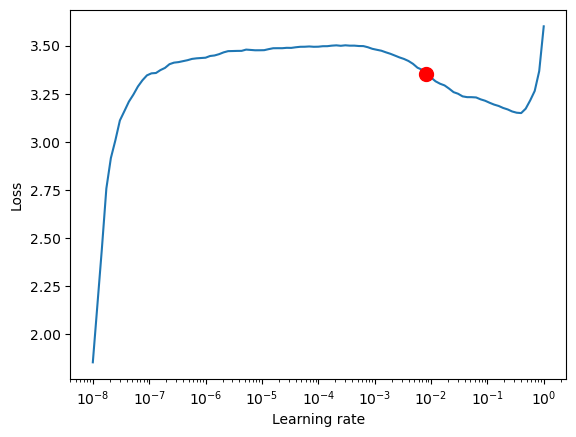

In [16]:
trainer = L.Trainer(
    # optimizer=torch.optim.Adam(),
    # loss_fn=loss_fn,
    devices="auto", # (os.cpu_count() / 2)
    # metrics=metrics,
    callbacks=[
        EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
        # L.ModelCheckpoint(
        #     monitor="val_loss",
        #     mode="min",
        #     save_top_k=1,
        #     save_path=f"{save_path}/checkpoints",
        #     filename="best_model",
        # ),
    ],
    logger=CSVLogger(save_dir="logs/", name="MLP-v0"),
    # min_epochs=1,
    max_epochs=100,
    precision='bf16-mixed',
)

# # Create a Tuner
tuner = Tuner(trainer)

# finds learning rate automatically
# sets hparams.lr or hparams.learning_rate to that learning rate
lr_finder = tuner.lr_find(multiclass_lightningmodel, datamodule=dm)
fig = lr_finder.plot(suggest=True)
#fig.savefig("lr_suggest.pdf")
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)
# update hparams of the model
multiclass_lightningmodel.learning_rate = new_lr

In [17]:
# NOTE: train.fit(), .validate(), .test() and .predict() all (re-)run dm.setup() when dataloader(s) are passed to these methods and pass the 'stage' parameter to .setup() to control the creation of the dataloaders.
#       When a datamodule is passed to these methods, a hook that generates the respective dataloader(s) is called. When
#       Validation is usually done during training, traditionally after each training epoch. It can be used for hyperparameter optimization or tracking model performance during training. It’s a part of the training process.
#       Testing is usually done once we are satisfied with the training and only with the best model selected from the validation metrics.
# trainer.fit(model=multiclass_lightningmodel, train_dataloaders=dm.train_dataloader()) # TODO: stage of The dataloader to use
trainer.fit(model=multiclass_lightningmodel, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader()) # stage of the dataloader to use
# trainer.validate() 
# trainer.test()


  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | MulticlassTabularMLP | 15.5 K
1 | train_acc | MulticlassF1Score    | 0     
2 | val_acc   | MulticlassF1Score    | 0     
3 | test_acc  | MulticlassF1Score    | 0     
---------------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 21: 100%|██████████| 833/833 [00:45<00:00, 18.13it/s, v_num=0, val_loss=2.290, val_F1_macro_weighted=0.296, train_F1_macro_weighted=0.276]


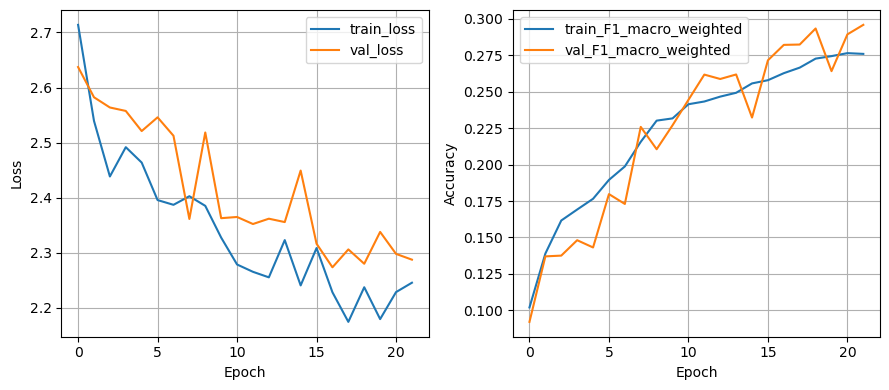

In [18]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
# Plot 1: Loss
df_metrics[["train_loss", "val_loss"]].plot(
    ax=axes[0], grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
# Plot 2: Accuracy
df_metrics[["train_F1_macro_weighted", "val_F1_macro_weighted"]].plot(
    ax=axes[1], grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy"
)

plt.tight_layout()
plt.show()

In [19]:
score = trainer.test(model=multiclass_lightningmodel, dataloaders=dm.test_dataloader())

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 261/261 [00:02<00:00, 96.01it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.2983810007572174     │
└───────────────────────────┴───────────────────────────┘

In [20]:
score[0]['test_F1_macro_weighted']

0.2983810007572174

In [21]:
# make predictions on test data and evaluate
preds_y_test = torch.cat(trainer.predict(model=multiclass_lightningmodel, dataloaders=dm.test_dataloader()))
# inverse transform to get back to original labels
preds_y_test = dm.label_encoder_target.inverse_transform(preds_y_test.reshape(-1, 1))
y_test = dm.label_encoder_target.inverse_transform(dm.test_dataset.get_dataframe.iloc[:, -1].values.reshape(-1, 1))
# calculate classification report
print(classification_report(y_test, preds_y_test))

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 261/261 [00:02<00:00, 105.49it/s]


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

   Blister and Insert Card       0.30      0.30      0.30      1749
  Blister and sealed blist       0.37      0.64      0.47      1582
            Book packaging       0.00      0.00      0.00        20
Cardb. Sleeve w - w/o Shr.       0.00      0.00      0.00       135
  Cardboard hanger w/o bag       0.00      0.00      0.00        80
    Carton cover (Lid box)       0.00      0.00      0.00       130
   Carton tube with or w/o       0.00      0.00      0.00        20
                      Case       0.00      0.00      0.00        97
         Corrugated carton       0.37      0.07      0.12       774
        Countertop display       0.00      0.00      0.00        30
                  Envelope       0.00      0.00      0.00        59
          Fabric packaging       0.00      0.00      0.00        20
            Folding carton       0.43      0.31      0.36      1644
              Hanger/ Clip       0.30      0.68

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## NN with HPO

### Performe HPO

In [22]:
class OptunaObjective(object):

    def __init__(self, dm: TabularDataModuleClassificationPACKAGING = None):
        self.dm = dm
        self.dm.prepare_data()
        self.dm.setup(stage='fit')

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_space_optuna = {
            'hidden_size': trial.suggest_categorical('hidden_size', [8, 16, 32, 64, 128]), # number of neurons in each layer
            'n_hidden_layers': trial.suggest_int("n_hidden_layers", 1, 6), # number of layers
            'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64]), # number of samples per batch
            'dropout': trial.suggest_categorical("dropout", [0.0, 0.1, 0.2, 0.4]), # dropout rate
        }

        self.dm.batch_size = hp_space_optuna['batch_size']

        multiclass_mlp = MulticlassTabularMLP(
            input_size=len(self.dm.feature_cols),
            output_size=self.dm.n_classes,
            hidden_size=hp_space_optuna['hidden_size'],
            n_hidden_layers=hp_space_optuna['n_hidden_layers'],
            dropout=hp_space_optuna['dropout'],
            norm=True,
        )

        multiclass_lightningmodel = MulticlassTabularLightningModule(
            n_classes=self.dm.n_classes,
            model=multiclass_mlp,
            learning_rate=0.001,
        )

        trainer = L.Trainer(
            devices="auto", # (os.cpu_count() / 2)
            callbacks=[
                EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
            ],
            # logger=CSVLogger(save_dir="logs/", name="my-model"),
            max_epochs=100,
            precision='bf16-mixed',
        )

        # Create a Tuner
        tuner = Tuner(trainer)
        lr_finder = tuner.lr_find(multiclass_lightningmodel, datamodule=self.dm) # finds learning rate automatically
        new_lr = lr_finder.suggestion()
        multiclass_lightningmodel.learning_rate = new_lr # update hparams of the model

        trainer.fit(
            model=multiclass_lightningmodel,
            train_dataloaders=self.dm.train_dataloader(),
            val_dataloaders=self.dm.val_dataloader()
        )

        score = trainer.test(model=multiclass_lightningmodel, dataloaders=self.dm.test_dataloader())

        return score[0]['test_F1_macro_weighted']

In [ ]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    dm=TabularDataModuleClassificationPACKAGING(
        data_dir='../../data/output/df_ml.csv',
        continuous_cols=['material_weight'],
        categorical_cols=[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'packaging_code'
        ],
        target=['packaging_category'],
        oversampling=True,
        test_size=0.2,
        val_size=0.2,
        batch_size=64,
        SEED=SEED # Ensure same data split as in other notebooks
    )
)

# define and run study for optimization
# define search strategy: RandomSampler
# study = optuna.create_study(direction="maximize", sampler=optuna.RandomSampler(seed=SEED))
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="nn_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=50,
    # timeout=600, 
    show_progress_bar=True
)

[I 2024-10-29 23:39:50,098] A new study created in memory with name: nn_optuna
  0%|          | 0/50 [00:00<?, ?it/s]Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider incr

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 5: 100%|██████████| 1666/1666 [00:49<00:00, 33.82it/s, v_num=32, val_loss=2.690, val_F1_macro_weighted=0.0199, train_F1_macro_weighted=0.0758]


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 521/521 [00:06<00:00, 84.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │   0.019927717745304108    │
└───────────────────────────┴───────────────────────────┘

Best trial: 0. Best value: 0.0199277:   2%|▏         | 1/50 [04:30<3:40:55, 270.53s/it]

[I 2024-10-29 23:44:20,620] Trial 0 finished with value: 0.019927717745304108 and parameters: {'hidden_size': 16, 'n_hidden_layers': 1, 'batch_size': 32, 'dropout': 0.2}. Best is trial 0 with value: 0.019927717745304108.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoade

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 22: 100%|██████████| 1666/1666 [01:17<00:00, 21.48it/s, v_num=33, val_loss=2.430, val_F1_macro_weighted=0.234, train_F1_macro_weighted=0.236]


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 521/521 [00:06<00:00, 82.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.23488712310791016    │
└───────────────────────────┴───────────────────────────┘

Best trial: 0. Best value: 0.0199277:   2%|▏         | 1/50 [35:46<3:40:55, 270.53s/it]

[I 2024-10-30 00:15:36,421] Trial 1 finished with value: 0.23488712310791016 and parameters: {'hidden_size': 128, 'n_hidden_layers': 3, 'batch_size': 32, 'dropout': 0.4}. Best is trial 1 with value: 0.23488712310791016.


Best trial: 1. Best value: 0.234887:   4%|▍         | 2/50 [35:46<16:11:51, 1214.82s/it]Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s]

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 36: 100%|██████████| 833/833 [00:43<00:00, 19.14it/s, v_num=34, val_loss=1.670, val_F1_macro_weighted=0.549, train_F1_macro_weighted=0.617]


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 261/261 [00:03<00:00, 78.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.5456754565238953     │
└───────────────────────────┴───────────────────────────┘

Best trial: 2. Best value: 0.545675:   6%|▌         | 3/50 [1:03:12<18:26:03, 1411.98s/it]Using bfloat16 Automatic Mixed Precision (AMP)


[I 2024-10-30 00:43:03,051] Trial 2 finished with value: 0.5456754565238953 and parameters: {'hidden_size': 128, 'n_hidden_layers': 2, 'batch_size': 64, 'dropout': 0.0}. Best is trial 2 with value: 0.5456754565238953.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_war

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 3333/3333 [01:47<00:00, 31.05it/s, v_num=35, val_loss=1.650, val_F1_macro_weighted=0.519, train_F1_macro_weighted=0.504]


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1042/1042 [00:10<00:00, 95.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.5183143019676208     │
└───────────────────────────┴───────────────────────────┘

[I 2024-10-30 02:15:56,724] Trial 3 finished with value: 0.5183143019676208 and parameters: {'hidden_size': 128, 'n_hidden_layers': 2, 'batch_size': 16, 'dropout': 0.2}. Best is trial 2 with value: 0.5456754565238953.

Best trial: 2. Best value: 0.545675:   6%|▌         | 3/50 [2:36:06<18:26:03, 1411.98s/it]

Best trial: 2. Best value: 0.545675:   8%|▊         | 4/50 [2:36:06<39:02:09, 3054.98s/it]Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 7: 100%|██████████| 833/833 [00:22<00:00, 37.81it/s, v_num=36, val_loss=2.660, val_F1_macro_weighted=0.0454, train_F1_macro_weighted=0.0616]


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 261/261 [00:03<00:00, 84.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.04543907567858696    │
└───────────────────────────┴───────────────────────────┘

Best trial: 2. Best value: 0.545675:  10%|█         | 5/50 [2:39:26<25:19:07, 2025.50s/it]

[I 2024-10-30 02:19:16,884] Trial 4 finished with value: 0.04543907567858696 and parameters: {'hidden_size': 8, 'n_hidden_layers': 2, 'batch_size': 64, 'dropout': 0.1}. Best is trial 2 with value: 0.5456754565238953.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoade

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 28: 100%|██████████| 833/833 [01:14<00:00, 11.23it/s, v_num=37, val_loss=2.220, val_F1_macro_weighted=0.327, train_F1_macro_weighted=0.332]


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 261/261 [00:04<00:00, 52.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.32738128304481506    │
└───────────────────────────┴───────────────────────────┘

[I 2024-10-30 02:56:28,144] Trial 5 finished with value: 0.32738128304481506 and parameters: {'hidden_size': 128, 'n_hidden_layers': 5, 'batch_size': 64, 'dropout': 0.2}. Best is trial 2 with value: 0.5456754565238953.


Best trial: 2. Best value: 0.545675:  12%|█▏        | 6/50 [3:16:38<25:36:40, 2095.46s/it]Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 18: 100%|██████████| 833/833 [00:25<00:00, 33.25it/s, v_num=38, val_loss=2.390, val_F1_macro_weighted=0.243, train_F1_macro_weighted=0.220]


/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 261/261 [00:03<00:00, 74.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.24626868963241577    │
└───────────────────────────┴───────────────────────────┘

Best trial: 2. Best value: 0.545675:  14%|█▍        | 7/50 [3:24:31<18:41:41, 1565.15s/it]

[I 2024-10-30 03:04:21,475] Trial 6 finished with value: 0.24626868963241577 and parameters: {'hidden_size': 32, 'n_hidden_layers': 1, 'batch_size': 64, 'dropout': 0.1}. Best is trial 2 with value: 0.5456754565238953.


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoade

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 39:  10%|█         | 339/3333 [00:11<01:37, 30.77it/s, v_num=39, val_loss=1.810, val_F1_macro_weighted=0.436, train_F1_macro_weighted=0.425] 

In [1]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

NameError: name 'study' is not defined

### Analyse HPO
Auswertung Optuna study

In [25]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_hidden_size,params_n_hidden_layers,state
0,0,0.049558,2024-10-29 23:17:17.787717,2024-10-29 23:18:54.354934,0 days 00:01:36.567217,32,0.1,16,2,COMPLETE
1,1,0.045439,2024-10-29 23:18:54.375414,2024-10-29 23:19:44.425687,0 days 00:00:50.050273,128,0.0,32,7,COMPLETE


In [26]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [27]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [28]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [30]:
best_trial.params

{'hidden_size': 16, 'n_hidden_layers': 2, 'batch_size': 32, 'dropout': 0.1}

In [ ]:
# Define best model

best_params = best_trial.params
# best_params = {
#     'max_depth': 50,
#     'criterion': 'entropy'
# }

# Test best model on test data again

dm=TabularDataModuleClassificationPACKAGING(
    data_dir='../../data/output/df_ml.csv',
    continuous_cols=['material_weight'],
    categorical_cols=[
        'material_number',
        'brand',
        'product_area',
        'core_segment',
        'component',
        'manufactoring_location',
        'characteristic_value',
        'packaging_code'
    ],
    target=['packaging_category'],
    oversampling=True,
    test_size=0.2,
    val_size=0.2,
    batch_size=best_params['batch_size'],
    SEED=SEED # Ensure same data split as in other notebooks
)
dm.prepare_data()
dm.setup(stage='fit')

# model
best_model = MulticlassTabularMLP(
    input_size=len(dm.feature_cols),
    output_size=dm.n_classes,
    hidden_size=best_params['hidden_size'],
    n_hidden_layers=best_params['n_hidden_layers'],
    dropout=best_params['dropout'],
    norm=True,
)

multiclass_lightningmodel = MulticlassTabularLightningModule(
    n_classes=dm.n_classes,
    model=multiclass_mlp,
    learning_rate=0.001,
)

trainer = L.Trainer(
    devices="auto", # (os.cpu_count() / 2)
    callbacks=[
        EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
    ],
    logger=CSVLogger(save_dir="logs/", name="MLP-Tuning"),
    max_epochs=100,
    precision='bf16-mixed',
)

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(multiclass_lightningmodel, datamodule=dm) # finds learning rate automatically
new_lr = lr_finder.suggestion()
multiclass_lightningmodel.learning_rate = new_lr # update hparams of the model

trainer.fit(
    model=multiclass_lightningmodel,
    train_dataloaders=dm.train_dataloader(),
    val_dataloaders=dm.val_dataloader()
)

score = trainer.test(model=multiclass_lightningmodel, dataloaders=dm.test_dataloader())
print(f"test_F1_macro_weighted: {score[0]['test_F1_macro_weighted']}")

# make predictions on test data and evaluate
preds_y_test = torch.cat(trainer.predict(model=multiclass_lightningmodel, dataloaders=dm.test_dataloader()))
# inverse transform to get back to original labels
preds_y_test = dm.label_encoder_target.inverse_transform(preds_y_test.reshape(-1, 1))
y_test = dm.label_encoder_target.inverse_transform(dm.test_dataset.get_dataframe.iloc[:, -1].values.reshape(-1, 1))
# calculate classification report
print(classification_report(y_test, preds_y_test))

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impr

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 2:  14%|█▍        | 233/1666 [00:08<00:49, 29.02it/s, v_num=44, val_loss=2.540, val_F1_macro_weighted=0.128, train_F1_macro_weighted=0.157] 

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

/opt/anaconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing DataLoader 0:  71%|███████   | 368/521 [00:08<00:03, 42.95it/s]